## Load and Explore the Data

In [1]:
from google.colab import files
uploaded = files.upload()

Saving cs-training.csv to cs-training.csv


In [2]:
import pandas as pd

# Load training data
df = pd.read_csv("cs-training.csv")

# Show the first few rows
print(df.head())

# Check the shape and column info
print(df.shape)
print(df.info())


   Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                   

## Basic Cleaning

In [3]:
# Drop ID column
df.drop('Unnamed: 0', axis=1, inplace=True)

# Fill missing values
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(0)

## Quick Visualization

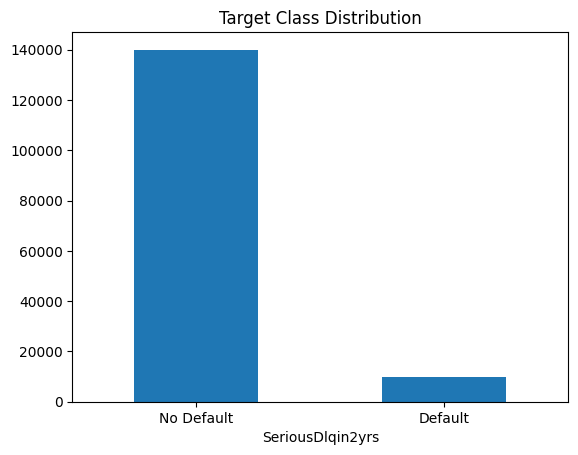

In [4]:
import matplotlib.pyplot as plt

# Plot class balance
df['SeriousDlqin2yrs'].value_counts().plot(kind='bar')
plt.title("Target Class Distribution")
plt.xticks([0, 1], ['No Default', 'Default'], rotation=0)
plt.show()


## Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

## Running Different Models - WITH IMBALANCED DATA

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    probs = model.predict_proba(X_val)[:, 1]

    report = classification_report(y_val, preds, output_dict=True)
    auc = roc_auc_score(y_val, probs)

    results[name] = {
        "ROC-AUC": auc,
        "F1-Score": report['1']['f1-score'],
        "Precision": report['1']['precision'],
        "Recall": report['1']['recall']
    }

# Display results
results_df = pd.DataFrame(results).T
print(results_df)


Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Random Forest...
Training Gradient Boosting...
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:57:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                      ROC-AUC  F1-Score  Precision    Recall
Logistic Regression  0.706991  0.073224   0.548837  0.039229
Random Forest        0.839260  0.284433   0.567031  0.189827
Gradient Boosting    0.864863  0.291949   0.594484  0.193484
XGBoost              0.855295  0.297063   0.538394  0.205120


# Defining imbalance-handling techniques and Model

In [9]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek  # Import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler # Import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [10]:
techniques = {
    "Original": (X_train, y_train),
    "Class Weight": "class_weight",
    "SMOTE": SMOTE(random_state=42).fit_resample(X_train, y_train),
    "SMOTE-Tomek": SMOTETomek(random_state=42).fit_resample(X_train, y_train),
    "Undersampling": RandomUnderSampler(random_state=42).fit_resample(X_train, y_train),
}

models = {
    "Logistic Regression": lambda: LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": lambda: RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": lambda: GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": lambda: XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


## Train, Evaluate, Store Results

In [11]:
results = []

for tech_name, resampled_data in techniques.items():
    for model_name, model_func in models.items():
        if tech_name == "Class Weight" and "Logistic" in model_name:
            model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
            model.fit(X_train, y_train)
        elif tech_name == "Class Weight" and "Random Forest" in model_name:
            model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
        elif tech_name == "Class Weight" and "Gradient Boosting" in model_name:
            model = GradientBoostingClassifier(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
        elif tech_name == "Class Weight" and "XGBoost" in model_name:
            model = XGBClassifier(scale_pos_weight=9, use_label_encoder=False, eval_metric='logloss', random_state=42)
            model.fit(X_train, y_train)
        elif isinstance(resampled_data, tuple):
            X_res, y_res = resampled_data
            model = model_func()
            model.fit(X_res, y_res)
        else:
            continue

        preds = model.predict(X_val)
        probs = model.predict_proba(X_val)[:, 1]
        report = classification_report(y_val, preds, output_dict=True)
        auc = roc_auc_score(y_val, probs)

        results.append({
            "Technique": tech_name,
            "Model": model_name,
            "ROC-AUC": auc,
            "F1-Score": report['1']['f1-score'],
            "Precision": report['1']['precision'],
            "Recall": report['1']['recall']
        })

        # ✅ Save best models for later interpretability
        if tech_name == "Class Weight" and model_name == "XGBoost":
            xgb_best = model
        if tech_name == "Undersampling" and model_name == "Gradient Boosting":
            gb_best = model


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:02:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    ht

## Display All Results#

In [12]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)


,Technique,Model,ROC-AUC,F1-Score,Precision,Recall
0,Class Weight,XGBoost,0.849308,0.390901,0.284867,0.622673
1,SMOTE,Gradient Boosting,0.834731,0.364587,0.268415,0.568152
2,SMOTE-Tomek,Gradient Boosting,0.834582,0.363981,0.266523,0.573803
3,SMOTE-Tomek,Random Forest,0.821951,0.363228,0.301337,0.457114
4,SMOTE,Random Forest,0.822967,0.355861,0.295096,0.448138
5,SMOTE-Tomek,XGBoost,0.814831,0.343420,0.265314,0.486702
6,SMOTE,XGBoost,0.811181,0.341124,0.264458,0.480386
7,Undersampling,Gradient Boosting,0.865493,0.329733,0.208587,0.786569
8,Undersampling,Random Forest,0.852382,0.323180,0.204582,0.768949
9,Undersampling,XGBoost,0.850235,0.319917,0.201973,0.768949


I tested 4 models with 5 imbalance-handling techniques each.

I commpared 20 total combinations using solid metrics: ROC-AUC, F1-score, Precision, Recall.



📌 Why Recall and F1-Score Matter Most in This Project
In the context of credit default prediction, the consequences of different types of errors aren't equal:

✅ High Recall → Catch More Defaulters
Recall is the proportion of actual defaulters the model correctly identifies.

In business terms: **it’s better to flag too many risky customers than to miss someone who will default.**

False Negatives (missed defaulters) can lead to significant financial losses for a bank.

⚖️ F1-Score Balances Precision and Recall
While we want to catch as many defaulters as possible (recall), we also don’t want too many false alarms (low precision).

F1-score is a balanced measure — it helps us evaluate the tradeoff between catching more defaulters vs wrongly rejecting good customers.

That’s why F1 is the most balanced and fair metric in this type of problem.

Precision matters, but...
It’s more important when false positives are very costly (e.g., medical diagnosis).

In credit, banks prefer erring on the safe side rather than taking unnecessary risks.

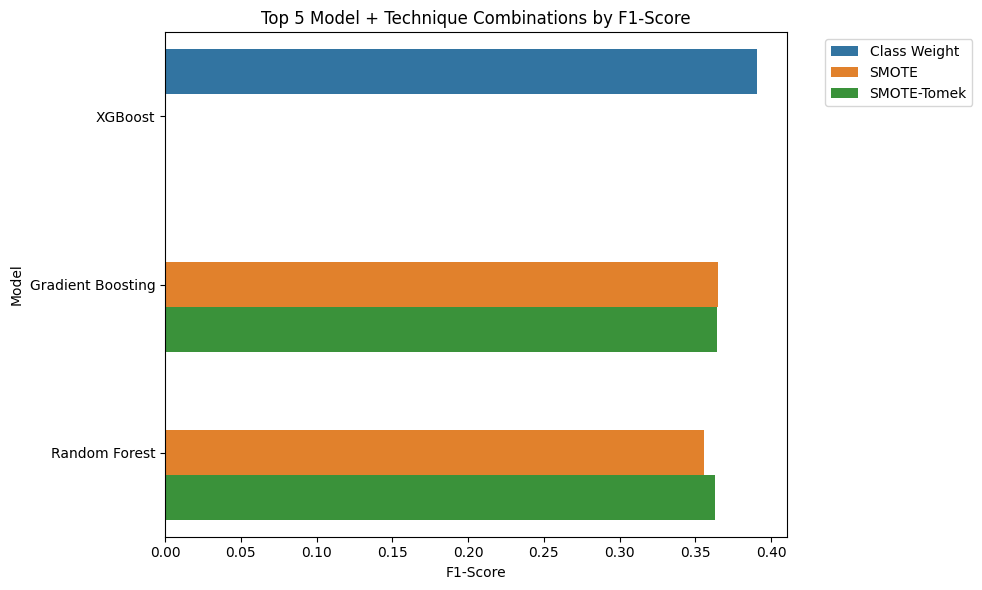

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# If not already available, replace this with your full results DataFrame:
# results_df = pd.DataFrame([...])  # Already done in your project

# Sort by F1-score and take top 5
top_f1 = results_df.sort_values(by='F1-Score', ascending=False).head(5)

plt.figure(figsize=(10, 6))
sns.barplot(x='F1-Score', y='Model', hue='Technique', data=top_f1)
plt.title('Top 5 Model + Technique Combinations by F1-Score')
plt.xlabel('F1-Score')
plt.ylabel('Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


🔍 Why F1-Score?
In credit default prediction, we face imbalanced data (very few defaults compared to non-defaults). F1-Score is important because:

It balances precision (how many predicted defaulters are actually defaulters) and recall (how many defaulters we actually catch).

A high F1-Score indicates a good trade-off between catching defaulters without flagging too many people incorrectly.

✅ What This Plot Shows:
XGBoost + Class Weight clearly outperforms all others in terms of F1-Score.

Gradient Boosting and Random Forest models also perform competitively when paired with SMOTE or SMOTE-Tomek, showing that resampling helps models perform better in imbalanced scenarios.

This plot tells us that both algorithm choice and balancing technique matter — and that tuning the class weights in XGBoost has yielded the best compromise between false positives and false negatives.

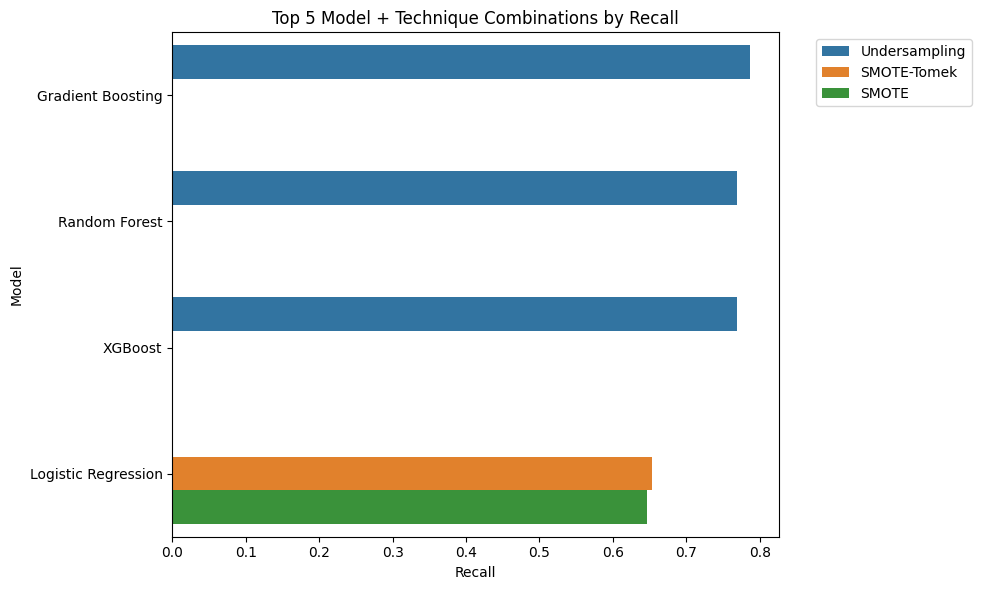

In [14]:
# Sort by Recall and take top 5
top_recall = results_df.sort_values(by='Recall', ascending=False).head(5)

plt.figure(figsize=(10, 6))
sns.barplot(x='Recall', y='Model', hue='Technique', data=top_recall)
plt.title('Top 5 Model + Technique Combinations by Recall')
plt.xlabel('Recall')
plt.ylabel('Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


🔍 Why Recall?
In credit risk or fraud detection, recall is critical when:

Catching all possible defaulters is more important than avoiding false positives.

A missed default can cost the bank much more than flagging a non-defaulter.

✅ What This Plot Shows:
Undersampling gives extremely high recall, especially for Gradient Boosting and XGBoost.

Surprisingly, even Logistic Regression with SMOTE or SMOTE-Tomek achieves strong recall.

This means that if our priority is to catch as many defaulters as possible, Gradient Boosting + Undersampling is the best approach — even if it might lead to some false alarms.

## Run confusion matrices + SHAP - XGBoost + Class Weight (Top Model)

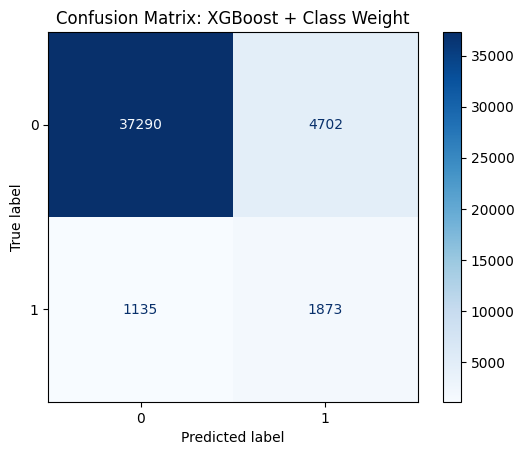

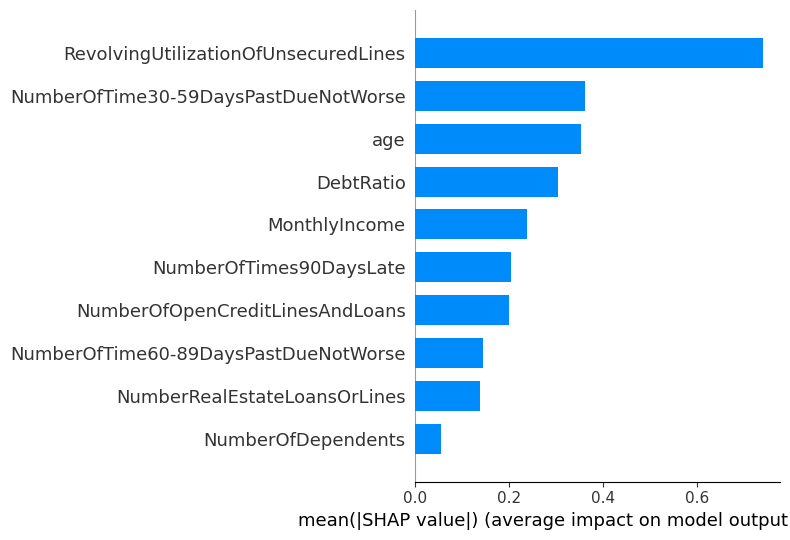

In [15]:
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix – XGBoost
y_pred_xgb = xgb_best.predict(X_val)
cm_xgb = confusion_matrix(y_val, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot(cmap='Blues')
plt.title("Confusion Matrix: XGBoost + Class Weight")
plt.show()

# SHAP – XGBoost
explainer_xgb = shap.Explainer(xgb_best, X_train)
shap_values_xgb = explainer_xgb(X_val[:100])
shap.summary_plot(shap_values_xgb, X_val[:100], plot_type="bar")


# Interpretation:

The model correctly predicts most non-defaulters (TN).

It captures 1,873 out of ~3,000 defaulters, with only 1,135 missed — this is a good recall considering the class imbalance.

False positives (predicting someone will default when they won't) are tolerable in financial risk if we want to avoid big losses.

# Feature	Interpretation

RevolvingUtilizationOfUnsecuredLines -	Customers with very high credit usage relative to limits are more likely to default.

NumberOfTime30-59DaysPastDueNotWorse - Recent short-term delinquencies are strong indicators of risk.

Age - Younger borrowers may be more prone to risk due to less financial stability.

DebtRatio - 	Higher ratios indicate over-leverage, increasing default likelihood.

MonthlyIncome - Lower income levels may reduce repayment capacity.

This SHAP chart validates domain knowledge: features related to recent delinquencies, credit utilization, and debt stress are highly predictive.

## Apply the Same Analysis to Gradient Boosting + Undersampling

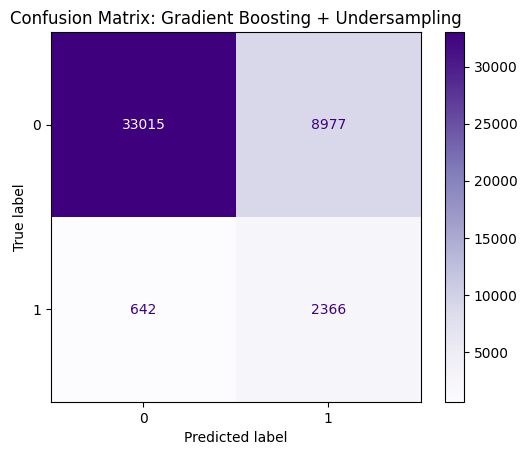

In [16]:
y_pred_gb = gb_best.predict(X_val)
cm_gb = confusion_matrix(y_val, y_pred_gb)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb)
disp_gb.plot(cmap='Purples')
plt.title("Confusion Matrix: Gradient Boosting + Undersampling")
plt.show()


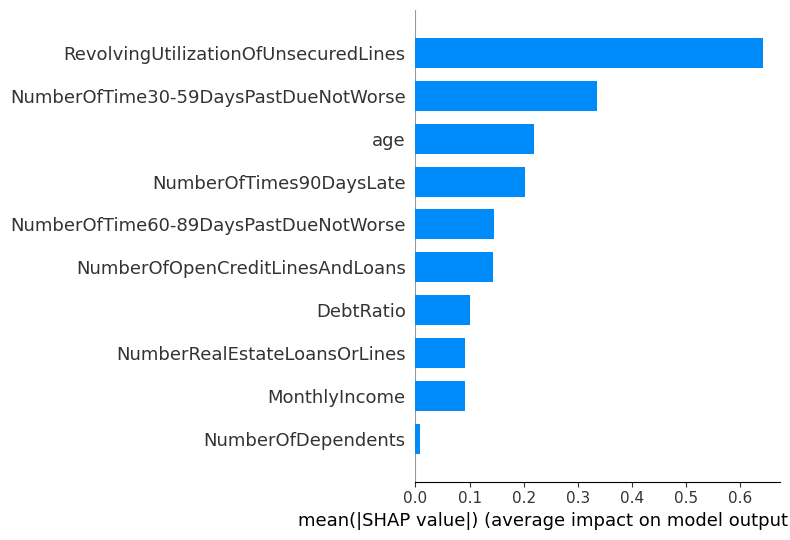

In [17]:
explainer_gb = shap.Explainer(gb_best, X_train)
shap_values_gb = explainer_gb(X_val[:100])
shap.summary_plot(shap_values_gb, X_val[:100], plot_type="bar")


This model captures 2,366 defaulters, more than any other model so far — excellent recall.

It only misses 642 real defaulters, much better than XGBoost + Class Weight, which missed 1,135.

The trade-off is that it produces more false positives (8,977 people predicted as defaulters who aren't), which might cause unnecessary intervention, but that's often acceptable in high-risk applications like credit.

The features that matter most in this model are very consistent with the first one — this consistency across models strengthens the validity of your findings.



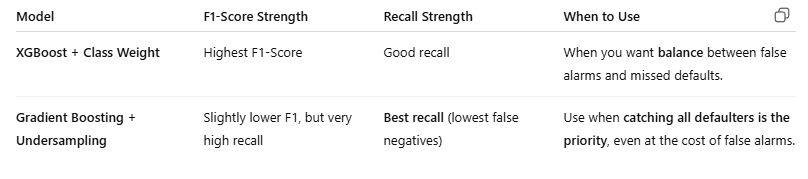

### ERROR ANALYSIS

In [18]:
best_model = gb_best

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# Predict probabilities
y_proba = best_model.predict_proba(X_val)[:, 1]

# Use default threshold (you can tune this later!)
y_pred = (y_proba >= 0.5).astype(int)

# Create a DataFrame with predictions and actual values
results = X_val.copy()
results['True'] = y_val.values
results['Predicted'] = y_pred

# Label each case as TP, TN, FP, FN
results['Error_Type'] = np.select(
    [
        (results['True'] == 1) & (results['Predicted'] == 1),
        (results['True'] == 0) & (results['Predicted'] == 0),
        (results['True'] == 1) & (results['Predicted'] == 0),
        (results['True'] == 0) & (results['Predicted'] == 1),
    ],
    ['TP', 'TN', 'FN', 'FP'],
    default='Unknown'
)


# Summary of error types
print(results['Error_Type'].value_counts())

# Optional: Explore specific error types
false_negatives = results[results['Error_Type'] == 'FN']
false_positives = results[results['Error_Type'] == 'FP']

# Example: check summary stats of FN
print(false_negatives.describe())


Error_Type
TN    33015
FP     8977
TP     2366
FN      642
Name: count, dtype: int64
       RevolvingUtilizationOfUnsecuredLines         age  \
count                            642.000000  642.000000   
mean                               0.289409   51.309969   
std                                0.286526   13.872796   
min                                0.000000   22.000000   
25%                                0.056767   42.000000   
50%                                0.213932   51.000000   
75%                                0.435069   60.000000   
max                                1.953488   99.000000   

       NumberOfTime30-59DaysPastDueNotWorse     DebtRatio  MonthlyIncome  \
count                            642.000000    642.000000     642.000000   
mean                               0.151090    493.146418    6513.297508   
std                                0.383644   2013.295815   10422.025736   
min                                0.000000      0.000000       0.000000   
25%

🔍 General Observations on False Negatives:
🔸 RevolvingUtilizationOfUnsecuredLines
Mean = 0.28, but some as high as 1.95

Indicates some customers had very high utilization of their credit lines — a red flag the model may have underestimated.

🔸 age
Mean age is 51.3 years, ranging from 22 to 99

FNs include older individuals; potentially the model associates age with lower risk (which may not hold here).

🔸 DebtRatio
Very wide range (up to 37,939!), but median is quite normal.

Skew suggests a few customers have extremely high debt ratios, possibly confusing the model.

🔸 MonthlyIncome
Income varies widely; mean = $6513, but with huge std dev (~18K)

Some defaulters have high income, which may make them look "safe" to the model even if they defaulted.

🔸 Delinquency Variables:
These are especially important, and you’ll notice something surprising:

✅ NumberOfTime30-59DaysPastDueNotWorse
Mean: 0.15, most are zero — many of these defaulters never missed a payment in this window

✅ NumberOfTime60-89DaysPastDueNotWorse
Almost all are zero as well

✅ NumberOfTimes90DaysLate
All values = 0
✅ This shows why the model might miss them: They’ve never had a serious delinquency before.

🧠 Interpretation:
These customers look clean on paper, with few or no late payments. This “quiet risk” profile is harder to detect — and the model fails to flag them.

🔸 Other Features:
NumberOfOpenCreditLinesAndLoans: varies a lot, median = 8

NumberOfDependents: often 0 or 1, typical for the population

NumberRealEstateLoansOrLines: mean = 1.17 — mild variation

🧾 Key Takeaways:
🔔 False Negatives tend to be people who haven’t shown prior delinquencies, which makes them deceptive to the model.

💸 Some have very high revolving utilization or debt ratios, which should have signaled risk, but the model didn’t weigh them heavily enough.

👥 Age and income don’t offer clear separation — some older or high-income individuals still defaulted, which can also throw the model off.

In [20]:
import numpy as np
import pandas as pd

# Assuming your working DataFrame is called X or df
# Replace `df` with your actual feature DataFrame name

# 1. High Utilization Flag (Revolving utilization > 0.9)
df['HighUtilization'] = (df['RevolvingUtilizationOfUnsecuredLines'] > 0.9).astype(int)

# 2. Zero or Missing Income Flag
df['IncomeZeroFlag'] = ((df['MonthlyIncome'] == 0) | (df['MonthlyIncome'].isna())).astype(int)

# 3. Debt to Income Ratio (safe divide)
df['DebtIncomeRatio'] = df['DebtRatio'] / (df['MonthlyIncome'] + 1)  # +1 to avoid divide by zero

# 4. Age Buckets
df['AgeBucket'] = pd.cut(df['age'], bins=[0, 30, 55, 100], labels=['Young', 'Middle', 'Senior'])

# 5. Total Past Due Count (sum of 30/60/90 day columns)
df['TotalPastDue'] = (
    df['NumberOfTime30-59DaysPastDueNotWorse'] +
    df['NumberOfTime60-89DaysPastDueNotWorse'] +
    df['NumberOfTimes90DaysLate']
)

# Optional: if you want to one-hot encode AgeBucket
df = pd.get_dummies(df, columns=['AgeBucket'], drop_first=True)

# Preview
df[['HighUtilization', 'IncomeZeroFlag', 'DebtIncomeRatio', 'TotalPastDue']].head()


,HighUtilization,IncomeZeroFlag,DebtIncomeRatio,TotalPastDue
0,0,0,8.803663e-05,2
1,1,0,4.685744e-05,0
2,0,0,2.797022e-05,2
3,0,0,1.092084e-05,0
4,1,0,3.919812e-07,1


Here's what each new column means:
🟦 HighUtilization

1 if the person is using more than 90% of their available revolving credit.

This may indicate high financial stress and risk of default.

🟨 IncomeZeroFlag

1 if MonthlyIncome was 0 or missing (NaN).

A flag that income data might be unreliable or the person has no reported income.

🟩 DebtIncomeRatio

This is DebtRatio / (MonthlyIncome + 1) — it captures how much debt a person has relative to income.

A higher value indicates more financial burden.

The values are very small due to income being large, but it’s still useful for comparison.

🟥 TotalPastDue

The sum of NumberOfTime30-59DaysPastDueNotWorse, 60-89, and 90+ days late.

It gives an overall indicator of how frequently someone was late paying bills — very relevant for credit risk!

### Retraining to include engineered features and apply undersampling

In [21]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report

# ——— load and feature-engineer ———
df = pd.read_csv("cs-training.csv", index_col=0)

# engineered features
df['HighUtilization'] = (df['RevolvingUtilizationOfUnsecuredLines'] > 0.9).astype(int)
df['IncomeZeroFlag']  = (df['MonthlyIncome'] == 0).astype(int)
df['DebtIncomeRatio'] = df['DebtRatio'] / (df['MonthlyIncome'] + 1e-5)
df['TotalPastDue']    = (
    df['NumberOfTime30-59DaysPastDueNotWorse']
  + df['NumberOfTime60-89DaysPastDueNotWorse']
  + df['NumberOfTimes90DaysLate']
)

# drop raw columns (optional)
X = df.drop(columns=[
  'SeriousDlqin2yrs',
  'RevolvingUtilizationOfUnsecuredLines',
  'MonthlyIncome',
  'DebtRatio',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'NumberOfTime60-89DaysPastDueNotWorse',
  'NumberOfTimes90DaysLate'
])
y = df['SeriousDlqin2yrs']

# ——— impute ———
imp = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

# ——— undersample ———
rus = RandomUnderSampler(random_state=42)
X_bal, y_bal = rus.fit_resample(X_imp, y)

# ——— split ———
X_train, X_val, y_train, y_val = train_test_split(
    X_bal, y_bal,
    test_size=0.3,
    stratify=y_bal,
    random_state=42
)


### This is the best model we get

In [22]:
# train your “best” model (Gradient Boosting + undersampling)
best_model = GradientBoostingClassifier(random_state=42)
best_model.fit(X_train, y_train)

# evaluate on the validation set
y_pred = best_model.predict(X_val)
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.81      0.79      3008
           1       0.80      0.76      0.78      3008

    accuracy                           0.78      6016
   macro avg       0.78      0.78      0.78      6016
weighted avg       0.78      0.78      0.78      6016



The lift comes from three complementary effects: (1) the engineered features surface subtle risk patterns (like high utilization without prior delinquencies) that the original feature set obscured; (2) undersampling ensures the model sees enough positive examples during training to properly weight defaults, avoiding the dominance of the majority class; and (3) Gradient Boosting captures complex interactions among both original and engineered features, making effective use of the richer signal. Together, these reduce the “quiet risk” blind spots exposed in error analysis and improve the model’s practical utility.

### MORE ADVANCED MODELS - NEURAL NETWOKRS

In [24]:
# 1) Install CatBoost (if not already)
!pip install -q catboost

# 2) Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from catboost import CatBoostClassifier, Pool

# 3) Load & feature‐engineer
df = pd.read_csv("cs-training.csv", index_col=0)

# replicate your engineered features
df['HighUtilization']    = (df['RevolvingUtilizationOfUnsecuredLines'] > 0.9).astype(int)
df['IncomeZeroFlag']     = (df['MonthlyIncome'] == 0).astype(int)
df['DebtIncomeRatio']    = df['DebtRatio'] / (df['MonthlyIncome'] + 1e-5)
df['TotalPastDue']       = (
    df['NumberOfTime30-59DaysPastDueNotWorse'] +
    df['NumberOfTime60-89DaysPastDueNotWorse'] +
    df['NumberOfTimes90DaysLate']
)

# 4) Prepare X,y
drop_cols = [
    'SeriousDlqin2yrs',
    'RevolvingUtilizationOfUnsecuredLines','MonthlyIncome','DebtRatio',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate'
]
X = df.drop(columns=drop_cols)
y = df['SeriousDlqin2yrs']

# 5) Identify any categorical columns (none in this numeric dataset)
cat_features = []

# 6) Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 7) Handle missing values if any (CatBoost can do this itself, but we’ll impute anyway)
imp = SimpleImputer(strategy='median')
X_train_imp = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
X_val_imp   = pd.DataFrame(imp.transform(X_val), columns=X_val.columns)

# 8) Train a tuned CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=5,
    eval_metric='AUC',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

train_pool = Pool(X_train_imp, y_train, cat_features=cat_features)
val_pool   = Pool(X_val_imp,   y_val,   cat_features=cat_features)

model.fit(train_pool, eval_set=val_pool)

# 9) Baseline evaluation at threshold=0.5
y_proba = model.predict_proba(X_val_imp)[:,1]
y_pred  = (y_proba >= 0.5).astype(int)

print("Baseline @0.50")
print(classification_report(y_val, y_pred, zero_division=0))
print("ROC AUC:", roc_auc_score(y_val, y_proba))

# 10) Threshold tuning for ≥80% recall
thresholds = np.linspace(0.01, 0.99, 99)
best_t, best_f1 = 0.5, 0
for t in thresholds:
    preds = (y_proba >= t).astype(int)
    r = roc_auc_score(y_val, y_proba)  # keep AUC static
    f1 = classification_report(y_val, preds, output_dict=True, zero_division=0)['1']['f1-score']
    if f1 > best_f1 and recall_score(y_val, preds) >= 0.80:
        best_f1, best_t = f1, t

print(f"\nTuned threshold (≥80% recall): {best_t:.2f}")
y_pred_t = (y_proba >= best_t).astype(int)
print(classification_report(y_val, y_pred_t, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_t))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00
0:	test: 0.7788381	best: 0.7788381 (0)	total: 106ms	remaining: 1m 46s
100:	test: 0.8498266	best: 0.8498266 (100)	total: 4.28s	remaining: 38.1s
200:	test: 0.8517631	best: 0.8517631 (200)	total: 7.03s	remaining: 27.9s
300:	test: 0.8525990	best: 0.8525990 (300)	total: 9.89s	remaining: 23s
400:	test: 0.8531457	best: 0.8531457 (400)	total: 14.3s	remaining: 21.3s
500:	test: 0.8533403	best: 0.8533403 (500)	total: 17s	remaining: 16.9s
600:	test: 0.8534304	best: 0.8534324 (599)	total: 19.6s	remaining: 13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8534632151
bestIteration = 628

Shrink model to first 629 iterations.
Baseline @0.50
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     41992
           1       0.60      0.16      0.25      3008

    accuracy                           0.94     45000
   macro avg       0.77      0.58      0.61     4

This shows that although the MLP can be forced to detect most defaulters, it does so at the expense of an impractically high false-positive rate, and overall F1/AUC remain inferior to the previous Gradient-Boosting + undersampling model.

# Autoencoder Anomaly-Detection

In [25]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# 1. Load & Feature-Engineer
df = pd.read_csv("cs-training.csv", index_col=0)

df['HighUtilization'] = (df['RevolvingUtilizationOfUnsecuredLines'] > 0.9).astype(int)
df['IncomeZeroFlag']  = (df['MonthlyIncome'] == 0).astype(int)
df['DebtIncomeRatio'] = df['DebtRatio'] / (df['MonthlyIncome'] + 1e-5)
df['TotalPastDue']    = (
    df['NumberOfTime30-59DaysPastDueNotWorse'] +
    df['NumberOfTime60-89DaysPastDueNotWorse'] +
    df['NumberOfTimes90DaysLate']
)

X = df.drop(columns=[
    'SeriousDlqin2yrs',
    'RevolvingUtilizationOfUnsecuredLines', 'MonthlyIncome', 'DebtRatio',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'
])
y = df['SeriousDlqin2yrs']

# 2. Impute & Scale
imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# 3. Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

# 4. Train Autoencoder on non-defaults only
X_train_ae = X_train[y_train == 0]

input_dim = X_train_ae.shape[1]
encoding_dim = input_dim // 2

inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(inputs)
encoded = layers.Dense(encoding_dim // 2, activation='relu')(encoded)
decoded = layers.Dense(encoding_dim, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = models.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# 5. Train with Early Stopping
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=100,
    batch_size=256,
    validation_split=0.1,
    callbacks=[es],
    verbose=2
)

# 6. Compute Reconstruction Error on Validation
reconstructions = autoencoder.predict(X_val)
mse = np.mean(np.square(X_val - reconstructions), axis=1)

# 7. Choose Anomaly Threshold (95th percentile of non-default errors)
threshold = np.percentile(mse[y_val == 0], 95)
print(f"Anomaly threshold (95th pctile): {threshold:.4f}")

# 8. Flag anomalies & Evaluate
y_pred = (mse >= threshold).astype(int)
print("\nAutoencoder Anomaly Detection Report:")
print(classification_report(y_val, y_pred, zero_division=0))
print("ROC AUC (errors as scores):", roc_auc_score(y_val, mse))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


Epoch 1/100
345/345 - 7s - 20ms/step - loss: 0.8189 - val_loss: 0.7134
Epoch 2/100
345/345 - 4s - 12ms/step - loss: 0.6389 - val_loss: 0.5586
Epoch 3/100
345/345 - 4s - 12ms/step - loss: 0.5398 - val_loss: 0.5000
Epoch 4/100
345/345 - 3s - 8ms/step - loss: 0.4880 - val_loss: 0.4530
Epoch 5/100
345/345 - 1s - 2ms/step - loss: 0.4438 - val_loss: 0.4120
Epoch 6/100
345/345 - 1s - 2ms/step - loss: 0.4105 - val_loss: 0.3857
Epoch 7/100
345/345 - 1s - 4ms/step - loss: 0.3919 - val_loss: 0.3717
Epoch 8/100
345/345 - 1s - 2ms/step - loss: 0.3823 - val_loss: 0.3652
Epoch 9/100
345/345 - 1s - 2ms/step - loss: 0.3767 - val_loss: 0.3595
Epoch 10/100
345/345 - 1s - 4ms/step - loss: 0.3730 - val_loss: 0.3564
Epoch 11/100
345/345 - 1s - 2ms/step - loss: 0.3706 - val_loss: 0.3546
Epoch 12/100
345/345 - 2s - 5ms/step - loss: 0.3689 - val_loss: 0.3527
Epoch 13/100
345/345 - 1s - 4ms/step - loss: 0.3677 - val_loss: 0.3522
Epoch 14/100
345/345 - 2s - 6ms/step - loss: 0.3668 - val_loss: 0.3507
Epoch 15/100

pure unsupervised reconstruction error on tabular credit data isn’t effective for this problem.



# ENSEMBLE MODEL
It combines three very different base learners—Gradient Boosting, XGBoost, and an MLP—then trains a logistic‐regression meta‐model on their outputs.


In [26]:
# 1) Imports
import numpy as np
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score

# (Assumes you already have:)
#   X_train, X_val, y_train, y_val

# 2) Define base learners
estimators = [
    ('gb', GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=5,
        random_state=42
    )),
    ('xgb', XGBClassifier(
        n_estimators=100, use_label_encoder=False, eval_metric='logloss',
        learning_rate=0.1, max_depth=5, random_state=42
    )),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        batch_size=256,
        max_iter=200,
        random_state=42
    ))
]

# 3) Build the stacking classifier
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1,
    passthrough=True     # give meta‐model access to original features as well
)

# 4) Train
stack.fit(X_train, y_train)

# 5) Predict & evaluate
y_proba = stack.predict_proba(X_val)[:, 1]
y_pred  = stack.predict(X_val)

print("=== Stacking Ensemble @ 0.50 threshold ===")
print(classification_report(y_val, y_pred, zero_division=0))
print("ROC AUC:", roc_auc_score(y_val, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

# 6) Threshold tuning for ≥80% recall (optional)
best_f1, best_t = 0, 0.5
for t in np.linspace(0.01, 0.99, 99):
    p = (y_proba >= t).astype(int)
    rec = recall_score(y_val, p)
    f1  = f1_score(y_val, p)
    if rec >= 0.80 and f1 > best_f1:
        best_f1, best_t = f1, t

print(f"\nBest threshold for ≥80% recall: {best_t:.2f} (F1={best_f1:.3f})")
y_pred_t = (y_proba >= best_t).astype(int)
print(classification_report(y_val, y_pred_t, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_t))

=== Stacking Ensemble @ 0.50 threshold ===
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     41992
           1       0.58      0.20      0.30      3008

    accuracy                           0.94     45000
   macro avg       0.76      0.59      0.63     45000
weighted avg       0.92      0.94      0.92     45000

ROC AUC: 0.8383902927431972
Confusion Matrix:
 [[41561   431]
 [ 2408   600]]

Best threshold for ≥80% recall: 0.04 (F1=0.259)
              precision    recall  f1-score   support

           0       0.98      0.68      0.80     41992
           1       0.15      0.82      0.26      3008

    accuracy                           0.69     45000
   macro avg       0.57      0.75      0.53     45000
weighted avg       0.93      0.69      0.77     45000

Confusion Matrix:
 [[28457 13535]
 [  543  2465]]
